# Mask detection
사진에 나온 사람들의 얼굴을 감지하여 마스크를 썼는지 파악하는 애플리케이션을 만들어보자

그러기 위해서는 먼저,
1. 얼굴을 감지해야하고,
2. 감지한 얼굴에 마스크 여부를 확인해야한다.

## 마스크 판독 모델 만들기
VGG19을 이용한 전이학습으로 모델을 만들고 저장한다

In [1]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input
from keras import Sequential
from keras.layers import Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load train and test set
train_dir = 'mask_data/Train'
test_dir = 'mask_data/Test'
val_dir = 'mask_data/Validation'

In [3]:
# Data augmentation

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

val_datagen = ImageDataGenerator(rescale=1.0/255)
val_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = train_datagen.flow_from_directory(directory=val_dir,target_size=(128,128),class_mode='categorical',batch_size=32)

Found 10000 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [4]:
vgg19 = VGG19(weights='imagenet',include_top=False,input_shape=(128,128,3))

for layer in vgg19.layers:
    layer.trainable = False
    
model = Sequential()
model.add(vgg19)
model.add(Flatten())
model.add(Dense(2,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 16386     
Total params: 20,040,770
Trainable params: 16,386
Non-trainable params: 20,024,384
_________________________________________________________________


In [5]:
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics ="accuracy")

In [6]:
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=len(train_generator)//32,
    epochs=15,validation_data=val_generator,
    validation_steps=len(val_generator)//32
)

c:\users\guest_01\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
9/9 [==============================] - 19s 856ms/step - loss: 0.5662 - accuracy: 0.7066
Epoch 2/15
9/9 [==============================] - 8s 817ms/step - loss: 0.2736 - accuracy: 0.8855
Epoch 3/15
9/9 [==============================] - 7s 778ms/step - loss: 0.1753 - accuracy: 0.9209
Epoch 4/15
9/9 [==============================] - 7s 783ms/step - loss: 0.1212 - accuracy: 0.9671
Epoch 5/15
9/9 [==============================] - 7s 801ms/step - loss: 0.1410 - accuracy: 0.9497
Epoch 6/15
9/9 [==============================] - 8s 819ms/step - loss: 0.1119 - accuracy: 0.9503
Epoch 7/15
9/9 [==============================] - 7s 799ms/step - loss: 0.1336 - accuracy: 0.9324
Epoch 8/15
9/9 [==============================] - 8s 820ms/step - loss: 0.0744 - accuracy: 0.9853
Epoch 9/15
9/9 [==============================] - 8s 822ms/step - loss: 0.0806 - accuracy: 0.9777
Epoch 10/15
9/9 [==============================] - 7s 794ms/step - loss: 0.1117 - accuracy: 0.9529
Epoch 11/15
9/9 [=

In [7]:
model.evaluate_generator(test_generator)

c:\users\guest_01\appdata\local\programs\python\python39\lib\site-packages\keras\engine\training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.09183833003044128, 0.9662500023841858]

모델을 저장하고, 라벨이 무엇을 의미하는지 매핑해놓는다

In [8]:
model.save('mask_model')
model.save('masknet.h5')

INFO:tensorflow:Assets written to: mask_model\assets


TypeError: cannot pickle 'weakref' object

In [9]:
mask_label = {0:'MASK',1:'NO MASK'}

## 얼굴 추적하기
opencv툴을 이용해 얼굴을 탐지하여 해당 부분을 모델에 넣어 마스크 여부를 판독한다

In [10]:
import cv2
#loading haarcascade_frontalface_default.xml
face_model = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

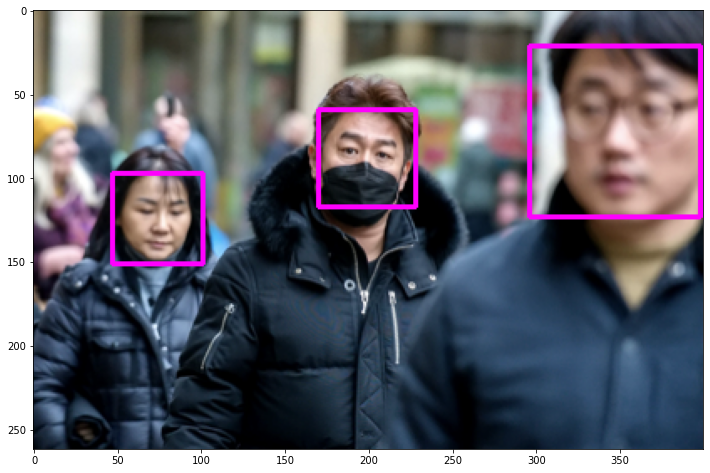

In [11]:
import matplotlib.pyplot as plt
#trying it out on a sample image
img = cv2.imread('many_face_data/images/maksssksksss244.png')

img = cv2.cvtColor(img, cv2.IMREAD_GRAYSCALE)

faces = face_model.detectMultiScale(img,scaleFactor=1.1, minNeighbors=4) #returns a list of (x,y,w,h) tuples

out_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image

#plotting
for (x,y,w,h) in faces:
    cv2.rectangle(out_img,(x,y),(x+w,y+h),(255,0,255),2)
plt.figure(figsize=(12,12))
plt.imshow(out_img)

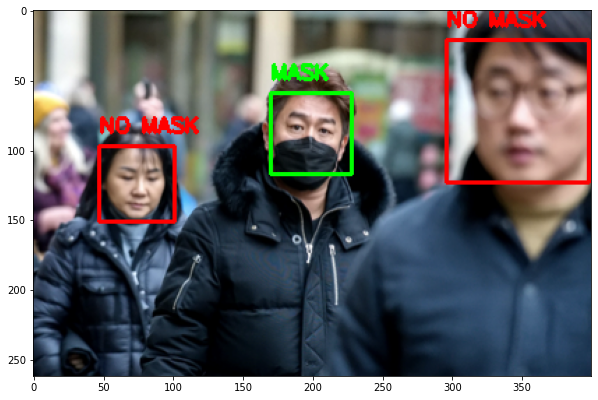

In [12]:
import numpy as np

new_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) #colored output image
for i in range(len(faces)):
    (x,y,w,h) = faces[i]
    crop = new_img[y:y+h,x:x+w]
    crop = cv2.resize(crop,(128,128))
    crop = np.reshape(crop,[1,128,128,3])/255.0
    mask_result = model.predict(crop)
    if mask_label[mask_result.argmax()] == 'MASK':
        cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y-10), 0 , 0.5, (0, 255, 0), 2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),(0, 255, 0),2)
    else:
        cv2.putText(new_img, mask_label[mask_result.argmax()], (x, y-10), 0, 0.5, (255, 0, 0), 2)
        cv2.rectangle(new_img,(x,y),(x+w,y+h),(255, 0, 0),2)
plt.figure(figsize=(10,10))
plt.imshow(new_img)